# Predicting the Severity of Road Traffic Accidents

https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall

## Table of contents
1. [Introduction: Problem](#intro)  
2. [Data Acquisition and Cleaning](#data)  
    2.1 [Data Source](#datasource)  
    2.2 [Data Vizualization and Pre-processing](#datacleanup)  
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Problem<a id='intro'></a>

Traffic accidents are a significant source of deaths, injuries, property damage, and a major concern for public health and traffic safety. Accidents are also a major cause of traffic congestion and delay. Effective management of accident is crucial to mitigating accident impacts and improving traffic safety and transportation system efficiency. Accurate predictions of severity can provide crucial information for emergency responders to **evaluate the severity level of accidents, locate accident blackspots, estimate the potential impacts, and implement efficient accident management procedures**.

Model can be applied to predictions of accident severity which is an essential step in accident management process. By recognizing those key influences, this report can provide suggestive results for **government and local authorities** to take effective measures to reduce accident impacts and improve traffic safety.

## 2. Data acquisition and cleaning <a id='data'></a>

### 2.1 Data source <a id='datasource'></a>

Dataset includes detailed information about collisions provided by Seattle Police Department and recorded by Traffic Records.

Based on definition of our problem, factors that will be taken into consideration for our predictions are:
* location of the collision to look out black spots
* weather, light and road conditions
* speeding, driving under influence and inattentive driving 
* address and junction type
* number of persons, pedestrians, bicycles and vehicles involved into incident
* some other

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

#### Loading Data from CSV file

In [2]:
df = pd.read_csv('Data-Collisions.csv')

In [3]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
df.shape

(194673, 38)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

#### Let's see how many of each class is in our data set

In [6]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

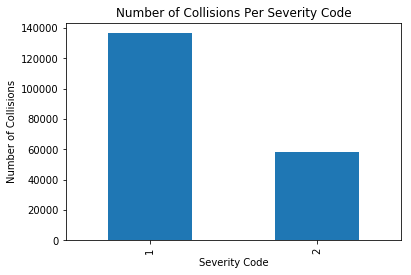

In [7]:
ax = df['SEVERITYCODE'].value_counts().plot(kind = 'bar')

ax.set_xlabel('Severity Code')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions Per Severity Code');

* 136485 incidents ended with **property damage** and 58188 involved **injury**. Our dataset is **imbalanced**.

###  2.2. Data Visualization and Pre-processing <a id='datacleanup'></a>

### Checking for Missing Data

#### Let's review and fill up missing values first, for that we will count number of Null values in each column

In [8]:
df.isnull().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE            1926
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SDOTCOLNUM         79737
SPEEDING          185340
ST_COLCODE            18
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

#### All missing values that we are interested in are categorical type. Some missing values will be replaced with mode, another - with 'Unknown' status, the rest will be converted from categorical to numeric values

In [9]:
# Replace all null values with mode
def nan_to_max_occ(item):
    df.loc[df[item].isnull(), [item]] = df[item].value_counts().idxmax()

In [10]:
# Replace all null values with 'Unknown'
def nan_to_unknown(item):    
    df.loc[df[item].isnull(), [item]] = 'Unknown'

In [11]:
# Converts categorical values into numeric
def nan_to_numeric(item):
    df.loc[df[item].isnull(), item] = 0
    df.loc[df[item] == 'N', item] = 0
    df.loc[df[item] == 'Y', item] = 1

In [12]:
for item in ['ADDRTYPE', 'COLLISIONTYPE', 'SDOT_COLCODE', 'ST_COLCODE']:
    nan_to_max_occ(item)

In [13]:
for item in ['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']:
    nan_to_unknown(item)

In [14]:
for item in ['INATTENTIONIND', 'SPEEDING', 'HITPARKEDCAR', 'PEDROWNOTGRNT']:
    nan_to_numeric(item)

In [15]:
df['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [16]:
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace=[np.nan, 'N', '0', 'Y', '1'], value=[0, 0, 0, 1, 1])

In [17]:
df['UNDERINFL'].value_counts()

0    185552
1      9121
Name: UNDERINFL, dtype: int64

In [18]:
df.isnull().sum()

SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE               0
INTKEY            129603
LOCATION            2677
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE          0
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE           0
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND               0
LIGHTCOND              0
PEDROWNOTGRNT          0
SDOTCOLNUM         79737
SPEEDING               0
ST_COLCODE             0
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

In [19]:
df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0          1               0.705603
           2               0.294397
1          1               0.609473
           2               0.390527
Name: SEVERITYCODE, dtype: float64

In [20]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])

In [21]:
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

In [22]:
df['INCDTTM'].head()

0   2013-03-27 14:54:00
1   2006-12-20 18:55:00
2   2004-11-18 10:20:00
3   2013-03-29 09:26:00
4   2004-01-28 08:04:00
Name: INCDTTM, dtype: datetime64[ns]

In [23]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,0,NaN,0,10,Entering at angle,0,0,0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,0,6354039.0,0,11,From same direction - both going straight - bo...,0,0,0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,0,4323031.0,0,32,One parked--one moving,0,0,0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,0,NaN,0,23,From same direction - all others,0,0,0
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,0,4028032.0,0,10,Entering at angle,0,0,0


### Reviewing Outliers for Numeric Features 

#### Number of persons involved in the collision with severity type:

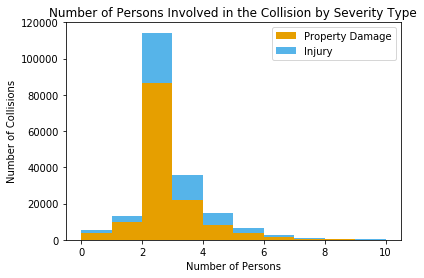

In [24]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PERSONCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PERSONCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 10], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Persons')
plt.ylabel('Number of Collisions')
plt.title('Number of Persons Involved in the Collision by Severity Type');

* Let's assume that any value above 10 for 'Person Count' will be equal to 10 in order to remove outliers.

In [25]:
df.loc[df['PERSONCOUNT'] > 10, 'PERSONCOUNT'] = 10

#### Number of pedestrians involved in the collision:

In [26]:
df['PEDCOUNT'].value_counts()

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

In [27]:
df.groupby('PEDCOUNT')['SEVERITYCODE'].value_counts(normalize=True)

PEDCOUNT  SEVERITYCODE
0         1               0.723295
          2               0.276705
1         2               0.898579
          1               0.101421
2         2               0.915929
          1               0.084071
3         2               0.954545
          1               0.045455
4         2               1.000000
5         2               1.000000
6         2               1.000000
Name: SEVERITYCODE, dtype: float64

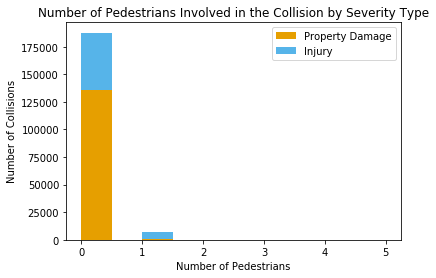

In [28]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PEDCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PEDCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 5], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Pedestrians')
plt.ylabel('Number of Collisions')
plt.title('Number of Pedestrians Involved in the Collision by Severity Type');

* Let's convert it into 0 or 1 values, so either pedestrians were involved into collision or not.

In [29]:
df.loc[df['PEDCOUNT'] > 1, 'PEDCOUNT'] = 1

#### Number of bicycles involved in the collision:

In [30]:
df['PEDCYLCOUNT'].value_counts()

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

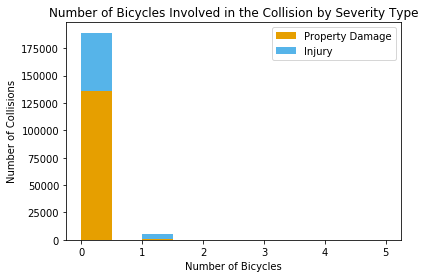

In [31]:
x1 = list(df[df['SEVERITYCODE'] == 1]['PEDCYLCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['PEDCYLCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 5], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Bicycles')
plt.ylabel('Number of Collisions')
plt.title('Number of Bicycles Involved in the Collision by Severity Type');

* Same way let's convert it into 0 or 1 values, so either bicycles were involved into collision or not.

In [32]:
df.loc[df['PEDCYLCOUNT'] > 1, 'PEDCYLCOUNT'] = 1

#### Number of vehicles involved in the collision:

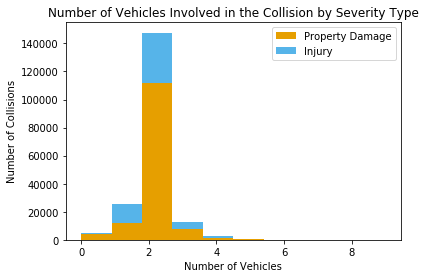

In [33]:
x1 = list(df[df['SEVERITYCODE'] == 1]['VEHCOUNT'])
x2 = list(df[df['SEVERITYCODE'] == 2]['VEHCOUNT'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 9], label=names, bins=10);

plt.legend()
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Collisions')
plt.title('Number of Vehicles Involved in the Collision by Severity Type');

In [34]:
df['VEHCOUNT'].value_counts()

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

* Let's assume that any value above 5 for 'Vehicle Count' will be equal 5 to remove outliers.

In [35]:
df.loc[df['VEHCOUNT'] > 5, 'VEHCOUNT'] = 5

In [36]:
df.groupby('VEHCOUNT')['SEVERITYCODE'].value_counts(normalize=True)

VEHCOUNT  SEVERITYCODE
0         1               0.758702
          2               0.241298
1         2               0.547810
          1               0.452190
2         1               0.756526
          2               0.243474
3         1               0.579554
          2               0.420446
4         1               0.555647
          2               0.444353
5         1               0.523873
          2               0.476127
Name: SEVERITYCODE, dtype: float64

### Extra features for out dataset

#### Reviewing the collision code given by SDOT

* Let's see if there any specific SDOT and ST collision codes that have high ratio of injuries and create new binary feature for anything that is higher than 50%. 

In [37]:
v = df.groupby('SDOT_COLCODE').SEVERITYCODE.value_counts().unstack()
df['SDOT_INJRATIO'] = df.SDOT_COLCODE.map(v[2] / (v[2] + v[1]))

In [38]:
df.loc[ (df['SDOT_INJRATIO'] > 0.5),'SDOT_INJ'] = 1
df['SDOT_INJ'] = df['SDOT_INJ'].fillna(0)

df['SDOT_INJ'].value_counts()

0.0    182389
1.0     12284
Name: SDOT_INJ, dtype: int64

In [39]:
v = df.groupby('ST_COLCODE').SEVERITYCODE.value_counts().unstack()
df['ST_INJRATIO'] = df.SDOT_COLCODE.map(v[2] / (v[2] + v[1]))

In [40]:
df.loc[ (df['ST_INJRATIO'] > 0.5),'ST_INJ'] = 1
df['ST_INJ'] = df['ST_INJ'].fillna(0)

df['ST_INJ'].value_counts()

0.0    178357
1.0     16316
Name: ST_INJ, dtype: int64

#### Reviewing Location column to see number of collisions occured in the same place.

In [41]:
df['LOCATION'].value_counts()[:10]

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                          276
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                          271
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N                                265
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST                                          254
6TH AVE AND JAMES ST                                                                    252
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST                                          239
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP                238
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST                                   231
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP              212
WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP    212
Name: LOCATION, dtype: int64

Let's add another column with number of collisions in that location and drop Location column

In [42]:
df['NUMINCLOCATION'] = df.groupby('LOCATION')['SEVERITYCODE'].transform('size')

In [43]:
df.loc[df['NUMINCLOCATION'].isnull(), 'NUMINCLOCATION'] = 0

In [44]:
df['NUMINCLOCATION'] = df['NUMINCLOCATION'].astype(np.int64)

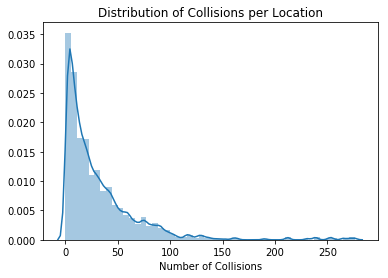

In [45]:
ax = sns.distplot(df['NUMINCLOCATION'])
ax.set(xlabel = 'Number of Collisions', title='Distribution of Collisions per Location')
plt.show()

#### Also add ratio of injuries for each location

In [46]:
v = df.groupby('LOCATION').SEVERITYCODE.value_counts().unstack()
df['LOCATIONINJRATIO'] = df.LOCATION.map(v[2] / (v[2] + v[1]))

#### Now let's assume that any location that had more than 5 collisions and injury ratio is higher than 50% will be considered as risky. 

In [47]:
df.loc[ (df['LOCATIONINJRATIO'] > 0.5) & (df['NUMINCLOCATION'] > 5) ,'INJLOCATION'] = 1
df['INJLOCATION'] = df['INJLOCATION'].fillna(0)

df['INJLOCATION'].value_counts()

0.0    175999
1.0     18674
Name: INJLOCATION, dtype: int64

In [48]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SDOT_INJRATIO,SDOT_INJ,ST_INJRATIO,ST_INJ,NUMINCLOCATION,LOCATIONINJRATIO,INJLOCATION
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0,0,0,0.285627,0.0,0.133543,0.0,31,0.483871,0.0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,0,0,0,0.069702,0.0,0.187182,0.0,190,0.321053,0.0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,0,0,0,0.326857,0.0,0.452295,0.0,34,0.088235,0.0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,0,0,0,0.285627,0.0,0.133543,0.0,27,0.222222,0.0
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0,0,0,0.285627,0.0,0.133543,0.0,28,0.285714,0.0


#### Let's see distribution of collisions across the week

In [49]:
df['DAYOFWEEK'] = df['INCDTTM'].dt.dayofweek

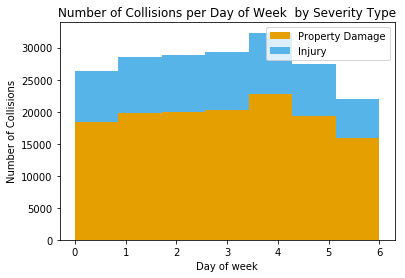

In [50]:
x1 = list(df[df['SEVERITYCODE'] == 1]['DAYOFWEEK'])
x2 = list(df[df['SEVERITYCODE'] == 2]['DAYOFWEEK'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[0, 6], label=names, bins=7);

plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions per Day of Week  by Severity Type');

In [51]:
df.groupby('DAYOFWEEK')['SEVERITYCODE'].value_counts(normalize=True)

DAYOFWEEK  SEVERITYCODE
0          1               0.697281
           2               0.302719
1          1               0.694250
           2               0.305750
2          1               0.695705
           2               0.304295
3          1               0.692470
           2               0.307530
4          1               0.704358
           2               0.295642
5          1               0.706196
           2               0.293804
6          1               0.722022
           2               0.277978
Name: SEVERITYCODE, dtype: float64

* Despite higher number of collisions on Friday, ratio between damages and injuries is constant during the week. 

#### How about distribution of collisions during the day

In [52]:
df['INCHOUR'] = df['INCDTTM'].dt.hour

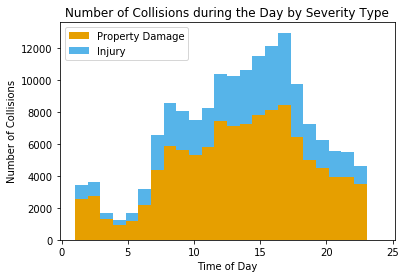

In [53]:
x1 = list(df[df['SEVERITYCODE'] == 1]['INCHOUR'])
x2 = list(df[df['SEVERITYCODE'] == 2]['INCHOUR'])

colors = ['#E69F00', '#56B4E9']
names = ['Property Damage', 'Injury']


plt.hist([x1, x2], color=colors, stacked=True, range=[1, 24], label=names, bins=24);

plt.legend()
plt.xlabel('Time of Day')
plt.ylabel('Number of Collisions')
plt.title('Number of Collisions during the Day by Severity Type');

* We see a spike of injuries during the day, so let's apply feature binarization for hours between 9:00 and 18:00. At the same time spike at midnight will not be taken into consideration as it also contains null values. 

In [54]:
df['RHOUR'] = df['INCHOUR'].apply(lambda x: 1 if (9 <= x <= 18) else 0)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,SDOT_INJRATIO,SDOT_INJ,ST_INJRATIO,ST_INJ,NUMINCLOCATION,LOCATIONINJRATIO,INJLOCATION,DAYOFWEEK,INCHOUR,RHOUR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0.285627,0.0,0.133543,0.0,31,0.483871,0.0,2,14,1
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,0.069702,0.0,0.187182,0.0,190,0.321053,0.0,2,18,1
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,0.326857,0.0,0.452295,0.0,34,0.088235,0.0,3,10,1
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,0.285627,0.0,0.133543,0.0,27,0.222222,0.0,4,9,1
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0.285627,0.0,0.133543,0.0,28,0.285714,0.0,2,8,0


In [55]:
df.loc[df['ST_INJRATIO'].isnull(), 'ST_INJRATIO'] = 0
df.loc[df['SDOT_INJRATIO'].isnull(), 'SDOT_INJRATIO'] = 0
df.loc[df['LOCATIONINJRATIO'].isnull(), 'LOCATIONINJRATIO'] = 0


### One Hot Encoding

#### Use one hot encoding technique to conver categorical variables to binary and append them to the feature Data Frame 

In [56]:
Feature = df[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND', 
         'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'SDOT_INJRATIO', 'ST_INJRATIO', 'LOCATIONINJRATIO', 'RHOUR']]

In [57]:
Feature = pd.concat([Feature, pd.get_dummies(df[['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 
                                                'ROADCOND', 'LIGHTCOND']])], axis=1)

In [58]:
Feature.head()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SDOT_INJRATIO,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,2,0,0,2,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0
1,2,0,0,2,0,0,0,0,0,0.069702,...,1,0,0,1,0,0,0,0,0,0
2,4,0,0,3,0,0,0,0,0,0.326857,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,3,0,0,0,0,0,0.285627,...,0,0,0,0,0,0,1,0,0,0
4,2,0,0,2,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0


### Feature Selection

In [59]:
X = Feature
X[0:5]

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SDOT_INJRATIO,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,2,0,0,2,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0
1,2,0,0,2,0,0,0,0,0,0.069702,...,1,0,0,1,0,0,0,0,0,0
2,4,0,0,3,0,0,0,0,0,0.326857,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,3,0,0,0,0,0,0.285627,...,0,0,0,0,0,0,1,0,0,0
4,2,0,0,2,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0


And our target variable:

In [60]:
y = df['SEVERITYCODE']
y[0:5]

0    2
1    1
2    1
3    1
4    2
Name: SEVERITYCODE, dtype: int64

### Train Test Split

In [61]:
from sklearn.model_selection import train_test_split

#Split our dataframe into Training and test with test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136271, 62) (136271,)
Test set: (58402, 62) (58402,)


## Normalize Data

Data Standardization give data zero mean and unit variance 

In [62]:
x_train_norm = X_train[['PERSONCOUNT', 'VEHCOUNT']]
x_train_scaled = preprocessing.StandardScaler().fit_transform(x_train_norm)

X_train[['PERSONCOUNT', 'VEHCOUNT']] = x_train_scaled

X_train[0:5]

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SDOT_INJRATIO,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
142628,-2.038498,0,0,0.130052,0,0,0,0,0,0.285627,...,0,0,0,0,0,0,1,0,0,0
93390,-0.365423,0,0,0.130052,0,0,0,0,0,0.072341,...,0,0,0,0,0,0,0,0,0,1
70952,-0.365423,0,1,-1.484148,0,0,0,0,0,0.880799,...,0,0,0,0,0,0,1,0,0,0
116356,-0.365423,0,0,0.130052,0,0,0,0,0,0.072341,...,1,0,0,0,0,0,1,0,0,0
113902,3.817264,0,0,0.130052,0,0,0,0,0,0.326857,...,0,0,0,0,0,0,1,0,0,0


In [63]:
x_test_norm = X_test[['PERSONCOUNT', 'VEHCOUNT']]
x_test_scaled = preprocessing.StandardScaler().fit_transform(x_test_norm)

X_test[['PERSONCOUNT', 'VEHCOUNT']] = x_test_scaled

X_test[0:5]

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SDOT_INJRATIO,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
181980,0.483329,0,0,0.134305,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0
163332,-0.360463,0,0,0.134305,0,0,0,0,0,0.285627,...,1,0,0,0,0,0,1,0,0,0
180525,-0.360463,0,0,0.134305,0,0,0,0,1,0.326857,...,1,0,0,1,0,0,0,0,0,0
1695,1.327122,0,0,1.763313,0,0,0,0,0,0.285627,...,0,0,0,1,0,0,0,0,0,0
143631,-2.048048,0,0,0.134305,0,0,0,0,0,0.326857,...,0,0,0,0,0,0,1,0,0,0


## Classification

Following algorithms will be used to build a model, and final report with F1-score and Jaccard Index provided:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


In [64]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix


recall = make_scorer(recall_score)

### Decision Tree 

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Train our model, make predictions and check accuracy
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train, y_train)

predTree = Tree.predict(X_test)

print("DecisionTree's f-1 score: {}".format(f1_score(y_test, predTree, average='weighted')))

DecisionTree's f-1 score: 0.6881035902846471


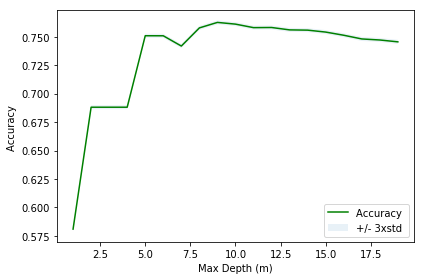

The best f1-score was with 0.7626258525351539 with m=9


In [66]:
# Let's build a plot with different number of Max Depth - M

Ms = 20

mean_acc = np.zeros((Ms-1))
std_acc = np.zeros((Ms-1))
ConfustionMx = [];

for m in range(1, Ms):
    
    #Train Model and Predict  
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth = m).fit(X_train,y_train)
    yhat=dtree.predict(X_test)
    mean_acc[m-1] = f1_score(y_test, yhat, average='weighted')

    
    std_acc[m-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1, Ms),mean_acc,'g')
plt.fill_between(range(1, Ms),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth (m)')
plt.tight_layout()
plt.show()

dtree = DecisionTreeClassifier(criterion="entropy", max_depth = mean_acc.argmax()+1).fit(X_train,y_train)
yhat = dtree.predict(X_test)

Tree_f1 = f1_score(y_test, yhat, average='weighted')

print( "The best f1-score was with {} with m={}".format(mean_acc.max(), mean_acc.argmax()+1)) 

              precision    recall  f1-score   support

           1       0.80      0.90      0.85     41083
           2       0.67      0.47      0.56     17319

   micro avg       0.78      0.78      0.78     58402
   macro avg       0.74      0.69      0.70     58402
weighted avg       0.76      0.78      0.76     58402

Confusion matrix, without normalization
[[37130  3953]
 [ 9146  8173]]


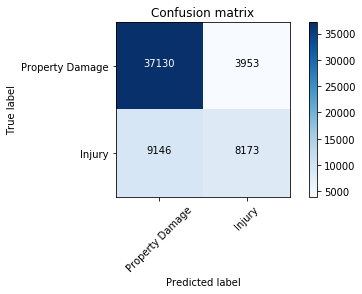

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Let's evaluate our model and build confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

#### As we see from confusion matrix predictions of injuries, which is more important than prediction of collisions, are quite poor with imbalanced dataset. Let's see if other algorithms can perform better. 

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
LR = LogisticRegression()

In [70]:
# Initialize and train Logistic Regression model
LR = LogisticRegression(C=1, solver='liblinear').fit(X_train,y_train)

# Predict values
predLR = LR.predict(X_test)

# Return estimates for all classes ordered by the label of classes
probLR = LR.predict_proba(X_test)

predLR[0:5]

array([1, 1, 1, 2, 1], dtype=int64)

              precision    recall  f1-score   support

           1       0.80      0.92      0.85     41083
           2       0.69      0.44      0.54     17319

   micro avg       0.77      0.77      0.77     58402
   macro avg       0.74      0.68      0.69     58402
weighted avg       0.76      0.77      0.76     58402

Confusion matrix, without normalization
[[37593  3490]
 [ 9656  7663]]


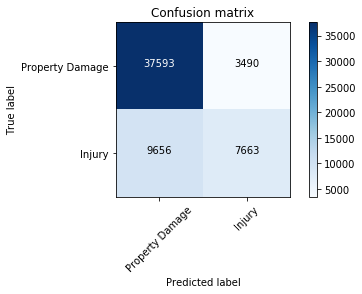

In [71]:
cnf_matrix = confusion_matrix(y_test, predLR, labels=[1, 2])
np.set_printoptions(precision=2)

print (classification_report(y_test, predLR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Property Damage", "Injury"], normalize=False,  title='Confusion matrix')

In [72]:
# For accuracy evaluation we will use Jaccard index
print("Jaccard Index: {}".format(jaccard_similarity_score(y_test, predLR)))
print("F1-Score: {}".format(metrics.f1_score(y_test, predLR, average='weighted')))

Jaccard Index: 0.7749049690079107
F1-Score: 0.7583876290892182


### Balancing Classes

There's several methods for balancing classes: 

* Random-Undersampling of Majority Class.

You reduce the size of majority class to match size of minority class. Disadvantage is that you may end up with very little data.

---
* SMOTE- Synthetic Minority Oversampling Technique.

Algorithm that creates a larger sample of minority class to match the size of majority class.

---

* Inverting Class Ratios. (Turning minority into majority)

If you turn the minority into the majority, you may skew results towards better recall scores(detecting injuries correctly), as opposed to better specificity scores.(detecting damages correctly)

#### For now, we balance with a variant implementation of SMOTE, to see correlations.

In [73]:
from imblearn.over_sampling import SMOTE, ADASYN
# Balancing Classes before checking for correlation

# Join the train data
train = X_train.join(y_train)

print('Data shape before balancing:',train.shape)
print('\nCounts of injuries VS damage in previous data:')
print(train.SEVERITYCODE.value_counts())
print('-'*40)

# Oversample injuries. Imblearn's ADASYN was built for class-imbalanced datasets
X_bal, y_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

# Join X and y
X_bal = pd.DataFrame(X_bal,columns=X_train.columns)
y_bal = pd.DataFrame(y_bal,columns=['SEVERITYCODE'])
balanced = X_bal.join(y_bal)


print('-'*40)
print('Data shape after balancing:',balanced.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(balanced.SEVERITYCODE.value_counts())

Data shape before balancing: (136271, 63)

Counts of injuries VS damage in previous data:
1    95402
2    40869
Name: SEVERITYCODE, dtype: int64
----------------------------------------
----------------------------------------
Data shape after balancing: (195728, 63)

Counts of frauds VS non-frauds in new data:
2    100326
1     95402
Name: SEVERITYCODE, dtype: int64


Distribution of the Severity Codes in the subsample dataset
2    0.736224
1    0.700090
Name: SEVERITYCODE, dtype: float64


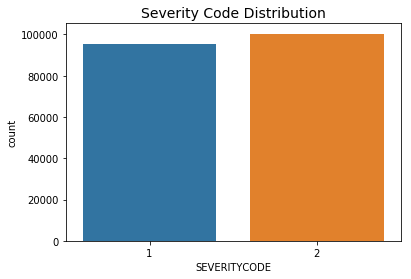

In [74]:
print('Distribution of the Severity Codes in the subsample dataset')
print(balanced.SEVERITYCODE.value_counts()/len(train))

sns.countplot('SEVERITYCODE', data=balanced)
plt.title('Severity Code Distribution', fontsize=14)
plt.show()

In [90]:
balanced.head()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SDOT_INJRATIO,...,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,SEVERITYCODE
0,-2.038498,0.0,0.0,0.130052,0.0,0.0,0.0,0.0,0.0,0.285627,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
1,-0.365423,0.0,0.0,0.130052,0.0,0.0,0.0,0.0,0.0,0.072341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,-0.365423,0.0,1.0,-1.484148,0.0,0.0,0.0,0.0,0.0,0.880799,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
3,-0.365423,0.0,0.0,0.130052,0.0,0.0,0.0,0.0,0.0,0.072341,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,3.817264,0.0,0.0,0.130052,0.0,0.0,0.0,0.0,0.0,0.326857,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


### Removing High-Correlation Outliers

* This step must be taken after balancing classes. Otherwise, correlations will echo class-distributions. 
* Based on a correlation matrix, we'll identify features with high correlations, and remove any transactions with outlying values in these.
* High correlation features have a high capacity to influence the algorith prediction. Therefore it's important to control their anomalies.
* This approach will reduce prediction bias because our algorithm will learn from more normally-distributed features.

In [76]:
# Each feature's correlation with Class
bal_corr = balanced.corr()
bal_corr.sort_values('SEVERITYCODE', ascending=False)['SEVERITYCODE']

SEVERITYCODE                                            1.000000
LOCATIONINJRATIO                                        0.396435
SDOT_INJRATIO                                           0.301188
JUNCTIONTYPE_At Intersection (intersection related)     0.185264
ADDRTYPE_Intersection                                   0.183439
PEDCOUNT                                                0.155237
COLLISIONTYPE_Rear Ended                                0.149421
COLLISIONTYPE_Pedestrian                                0.149192
PERSONCOUNT                                             0.142530
PEDCYLCOUNT                                             0.135837
COLLISIONTYPE_Cycles                                    0.134978
PEDROWNOTGRNT                                           0.127098
COLLISIONTYPE_Angles                                    0.117188
LIGHTCOND_Daylight                                      0.091852
COLLISIONTYPE_Left Turn                                 0.068583
ROADCOND_Dry             

#### Approach to removing outliers:

**For features of high positive correlation** - remove damage outliers on the top range, (improve recall) and remove injury outliers on the bottom range. (improve specificity)

**For features of high negative correlation** - remove damage outliers on the bottom range, (improve recall) and remove injury outliers on the top range. (improve specificity)

In [77]:
no_outliers=pd.DataFrame(balanced.copy())

In [78]:
# Removing Outliers from high-correlation features

cols = bal_corr.SEVERITYCODE.index[:-1]

# For each feature correlated with Class...
for col in cols:
    # If absolute correlation value is more than X percent...
    correlation = bal_corr.loc['SEVERITYCODE',col]
    if np.absolute(correlation) > 0.1:
        
        # Separate the classes of the high-correlation column
        damages = no_outliers.loc[no_outliers.SEVERITYCODE==1,col]
        injuries = no_outliers.loc[no_outliers.SEVERITYCODE==2,col]

        # Identify the 25th and 75th quartiles
        all_values = no_outliers.loc[:,col]
        q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
        # Get the inter quartile range
        iqr = q75 - q25
        # Smaller cutoffs will remove more outliers
        cutoff = iqr * 7
        # Set the bounds of the desired portion to keep
        lower, upper = q25 - cutoff, q75 + cutoff
        
        # If positively correlated...
        # Drop nonfrauds above upper bound, and frauds below lower bound
        if correlation > 0: 
            no_outliers.drop(index=damages[damages>upper].index,inplace=True)
            no_outliers.drop(index=injuries[injuries<lower].index,inplace=True)
        
        # If negatively correlated...
        # Drop nonfrauds below lower bound, and frauds above upper bound
        elif correlation < 0: 
            no_outliers.drop(index=damages[damages<lower].index,inplace=True)
            no_outliers.drop(index=injuries[injuries>upper].index,inplace=True)
        
print('\nData shape before removing outliers:', balanced.shape)
print('\nCounts of frauds VS non-frauds in previous data:')
print(balanced.SEVERITYCODE.value_counts())
print('-'*40)
print('-'*40)
print('\nData shape after removing outliers:', no_outliers.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(no_outliers.SEVERITYCODE.value_counts())


Data shape before removing outliers: (195728, 63)

Counts of frauds VS non-frauds in previous data:
2    100326
1     95402
Name: SEVERITYCODE, dtype: int64
----------------------------------------
----------------------------------------

Data shape after removing outliers: (149653, 63)

Counts of frauds VS non-frauds in new data:
2    83499
1    66154
Name: SEVERITYCODE, dtype: int64


* Outliers from high-correlation features are now gone. However, this created a class-imbalance again.
* I will balance the classes later when I reduce the model size. Reduction is important because classifiers may lag on high-dimensional datasets.

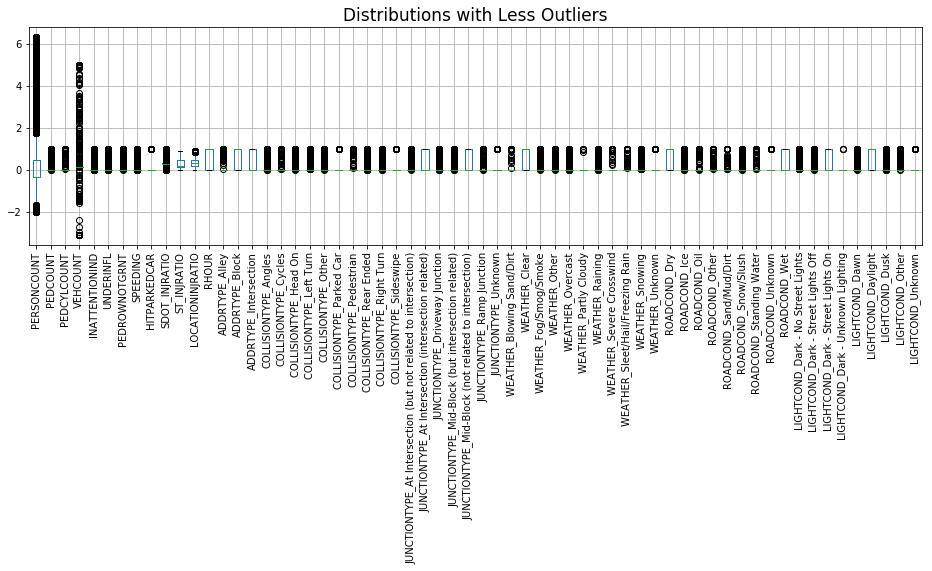

In [79]:
no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
plt.title('Distributions with Less Outliers', fontsize=17)
plt.show()

* I'll use the correlation matrix again, but this time I'll filter out features with low predictive power, instead of outliers.

In [80]:
feat_sel =pd.DataFrame(no_outliers.copy())

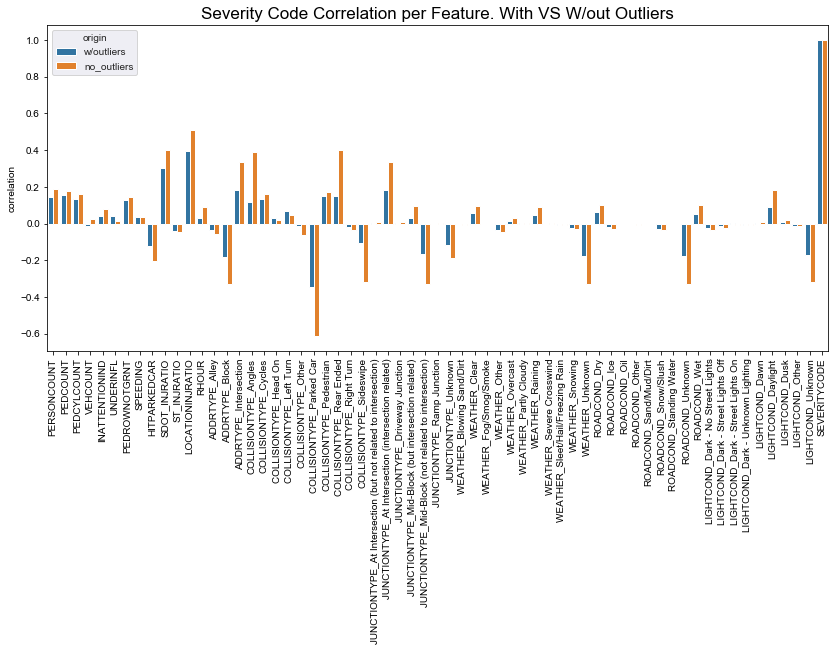

In [81]:
# Make a dataframe with the class-correlations before removing outliers
corr_change = pd.DataFrame()
corr_change['correlation']= bal_corr.SEVERITYCODE
corr_change['origin']= 'w/outliers'

# Make a dataframe with class-correlations after removing outliers 
corr_other = pd.DataFrame()
corr_other['correlation']= feat_sel.corr().SEVERITYCODE
corr_other['origin']= 'no_outliers'

# Join them
corr_change = corr_change.append(corr_other)

plt.figure(figsize=(14,6))
plt.xticks(rotation=90)

# Plot them
sns.set_style('darkgrid')
plt.title('Severity Code Correlation per Feature. With VS W/out Outliers', fontsize=17)
sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
plt.show()

* It's obvious that most features gained correlation power, regardless of direction. Positive correlations went higher up, negative correlations went lower down. Also, the highest correlations flattened out, while the smallest ones rose to relevance.
* It is clearly an indicator that the outliers were causing noise, and therefore dimming the correlation-potential of each feature.

In [82]:
# Feature Selection based on correlation with Class

print('\nData shape before feature selection:', feat_sel.shape)
print('\nCounts of frauds VS non-frauds before feature selection:')
print(feat_sel.SEVERITYCODE.value_counts())
print('-'*40)

# Correlation matrix after removing outliers
new_corr = feat_sel.corr()

for col in new_corr.SEVERITYCODE.index[:-1]:
    # Pick desired cutoff for dropping features. In absolute-value terms.
    if np.absolute(new_corr.loc['SEVERITYCODE',col]) < 0.1:
        # Drop the feature if correlation is below cutoff
        feat_sel.drop(columns=col,inplace=True)

print('-'*40)
print('\nData shape after feature selection:', feat_sel.shape)
print('\nCounts of frauds VS non-frauds in new data:')
print(feat_sel.SEVERITYCODE.value_counts())


Data shape before feature selection: (149653, 63)

Counts of frauds VS non-frauds before feature selection:
2    83499
1    66154
Name: SEVERITYCODE, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (149653, 25)

Counts of frauds VS non-frauds in new data:
2    83499
1    66154
Name: SEVERITYCODE, dtype: int64


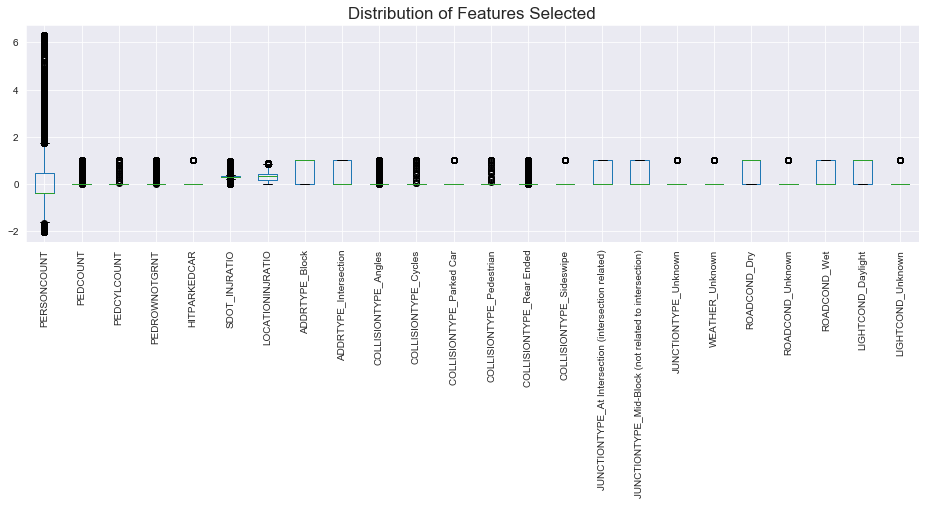

In [83]:
feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
plt.title('Distribution of Features Selected', fontsize=17)
plt.show()

* So this removed a few features from our 'processed' dataset. Aside from its large size, it should be ready for predictions.

### Test and Compare Classifiers

* I'll evaluate improvements based on **injury recall**, since its crucial to predict injuries. This might come at the expense of more false-alarms, which would decrease the overall accuracy. **The main purpose of this project will be to identify all injuries, while minimizing false-positives.**

* I'll define outcomes and predictors, reduce model size, and classify.

In [84]:
from imblearn.under_sampling import RandomUnderSampler
# Undersample model for efficiency and balance classes.
# X_train = feat_sel.drop('SEVERITYCODE', 1)
# y_train = feat_sel.SEVERITYCODE

X_train = balanced.drop('SEVERITYCODE', 1)
y_train = balanced.SEVERITYCODE

# After feature-selection, X_test needs to include only the same features as X_train
cols = X_train.columns
X_test = X_test[cols]

# Undersample and balance classes
X_train, y_train = RandomUnderSampler(sampling_strategy={2:20000,1:20000}).fit_resample(X_train,y_train)

print('\nX_train shape after reduction:', X_train.shape)
print('\nCounts of Injuries VS Damages in y_train:')
print(np.unique(y_train, return_counts=True))


X_train shape after reduction: (40000, 62)

Counts of Injuries VS Damages in y_train:
(array([1, 2], dtype=int64), array([20000, 20000], dtype=int64))


* Here, I'll try a few simple classifiers and compare their performance.

In [85]:
# DataFrame to store classifier performance

performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])



 ---------------------------------------- 
 SVC 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.01 0.08 0.04]
Mean recall score: 0.04539986772038535

TEST GROUP

Recall: 0.014580240001947277


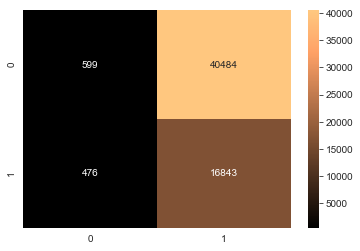


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.66 0.65 0.66]
Mean recall score: 0.657149973284414

TEST GROUP

Recall: 0.6583501691697295


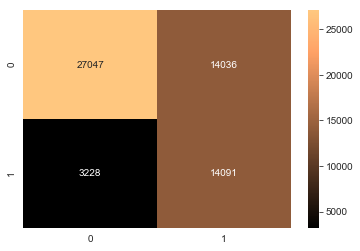


 ---------------------------------------- 
 DecisionTreeClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.7  0.71 0.71]
Mean recall score: 0.7080501435474281

TEST GROUP

Recall: 0.5169291434413261


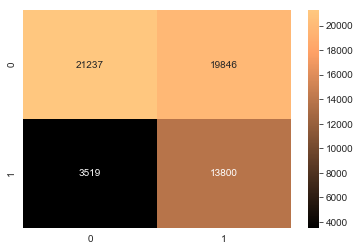


 ---------------------------------------- 
 KNeighborsClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.63 0.64 0.65]
Mean recall score: 0.6388003582119124

TEST GROUP

Recall: 0.616751454372855


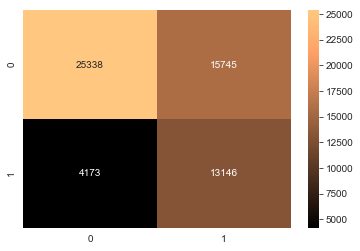

In [86]:
# Load simple classifiers
classifiers = [SVC(max_iter=1000),LogisticRegression(),
               DecisionTreeClassifier(),KNeighborsClassifier()]

# Get a classification report from each algorithm
for clf in classifiers:    
    
    # Heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    
    # Cross-validate on the train data
    print("TRAIN GROUP")
    train_cv = cross_val_score(X=X_train, y=y_train, 
                               estimator=clf, scoring=recall,cv=3)
    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\nRecall:",recall_score(y_test,y_pred))
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    # Store results
    performance.loc[clf.__class__.__name__+'_default',
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()
    ]

In [87]:
performance

,Train_Recall,Test_Recall,Test_Specificity
SVC_default,0.0453999,0.0145802,0.0145802
LogisticRegression_default,0.65715,0.65835,0.65835
DecisionTreeClassifier_default,0.70805,0.516929,0.516929
KNeighborsClassifier_default,0.6388,0.616751,0.616751


* These results are very promising for a first run, considering I didn't tweak any of the parameters.
* Now let's do a GridSearchCV to find the best parameters for these classifiers.


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'C': 1, 'penalty': 'l1', 'solver': 'saga'} 

TRAIN GROUP

Cross-validation recall scores: [0.5  0.49 0.49]
Mean recall score: 0.4930998124561219

TEST GROUP

Recall: 0.4919553099822311
              precision    recall  f1-score   support

           1       0.94      0.49      0.65     41083
           2       0.43      0.92      0.59     17319

   micro avg       0.62      0.62      0.62     58402
   macro avg       0.69      0.71      0.62     58402
weighted avg       0.79      0.62      0.63     58402



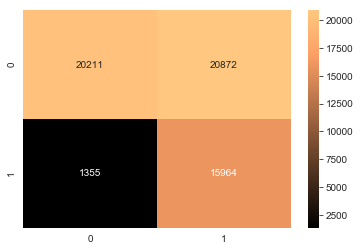

In [88]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1, # Use all CPU
    class_weight={1:0.5,2:1} # Prioritize injuries
)

# Load GridSearchCV
search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    n_jobs=-1,
    scoring=recall
)

# Train search object
search.fit(X_train, y_train)

# Heading
print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

# Extract best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, 
                           estimator=best, scoring=recall,cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())

# Now predict on the test group
print("\nTEST GROUP")
y_pred = best.fit(X_train, y_train).predict(X_test)
print("\nRecall:",recall_score(y_test,y_pred))

# Get classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
    
# Store results
performance.loc[clf.__class__.__name__+'_search',
                ['Train_Recall','Test_Recall','Test_Specificity']] = [
    train_cv.mean(),
    recall_score(y_test,y_pred),
    conf_matrix[0,0]/conf_matrix[0,:].sum()
]

In [89]:
performance

,Train_Recall,Test_Recall,Test_Specificity
SVC_default,0.0453999,0.0145802,0.0145802
LogisticRegression_default,0.65715,0.65835,0.65835
DecisionTreeClassifier_default,0.70805,0.516929,0.516929
KNeighborsClassifier_default,0.6388,0.616751,0.616751
LogisticRegression_search,0.4931,0.491955,0.491955
